## 3. Simulation  

<p> In previous chapter, I generated a set of data with low and high correlation. However, only one instance is not enough to make general conclusion about the relationship between Ridge/LASSO and correlation. Using codes that I wrote in last chapter, it should be easy to design simulations.

In [30]:
## Code from previous chapter

# Import library
import numpy as np
from numpy import random as random 
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model


#` Generate closest positive semi-definite matrix from matrix
#`
#` @param A squared matrix
#` @return 'pxp' positive semi-matrix that being the closest from A
#` @detail this algorithm is proven in Higham's 1988 paper
#`         code written by tjiagoM from stackoverflow.com
#` get_near_psd: Matrix -> Matrix
def get_near_psd(A):
    C = (A + A.T)/2
    eigval, eigvec = np.linalg.eig(C)
    eigval[eigval < 0] = 0

    return eigvec.dot(np.diag(eigval)).dot(eigvec.T)

#` Generate correlation matrix of given level
#` 
#` @param nvar number of variables(p)
#` @param scale level of correlation. expecting one of 'low' or 'high'
#` @return pxp correltion-like positive semi-definite matrix
#` @detail 'low' restricts non-diagonal entries to have 0 <= abs(rho) <= 0.5
#`         'high': 0.5 < abs(rho) <= 1.0
#` gen_corr: int string -> Matrix
def gen_corr(nvar, scale={'low','high'}):
    iden_mat = np.identity(nvar)
    elem = np.empty(nvar**2-nvar)
    i = 0
    while i < (nvar**2-nvar):
        draw = random.uniform(-1,1,1)
        if scale == 'low':
            if abs(draw) <= 0.5: 
                elem[i] = draw
                i = i + 1
        elif scale == 'high':
            if abs(draw) > 0.5:
                elem[i] = draw
                i = i + 1
        else: break
  
    iden_mat[iden_mat != 1] = elem
    corr = get_near_psd(iden_mat)
    
    return corr

#` Generate covariance matrix from correlation matrix
#` 
#` @param corr pxp correlation matrix
#` @param std vector length p of standard deviation, default set to None
#` @param std_range range of std, default set to [1,5]
#` @return pxp covariance matrix
#` @detail Cov = corr * (std * std.transpose)
#`         if std is not specified, it will be sampled within std_range
#` corr2cov: Matrix Bool IntRange -> Matrix
def corr2cov(corr, std=None, std_range=[1,5]):
    nvar = corr.shape[0]
    if std is None:
        std = random.uniform(std_range[0],std_range[1],nvar)
    
    cov = corr * np.outer(std,std)

    return cov

+ Simulating

In [32]:
# setting
random.seed(1)
nvar = 2
low,high = -5,5
nsamp = 500
ntrain = int(0.8*nsamp)
nsim = 100
result = np.zeros((2,3,nsim))

for i in range(nsim):
    # Correlation and covariance matrices
    corr_low = gen_corr(nvar,'low')
    corr_high = gen_corr(nvar,'high')

    cov_low = corr2cov(corr_low)
    cov_high = corr2cov(corr_high)

    # Generating datapoints from multivariate normal distribution
    means = np.around(random.uniform(low,high,nvar),2)
    X_low = random.multivariate_normal(means,cov_low,nsamp)
    X_high = random.multivariate_normal(means,cov_high,nsamp)

    # Generate coefficients and finally Y
    beta = np.array([np.around(random.normal(low,high,nvar),3)]).transpose()
    Y_lmean = np.matmul(X_low,beta)
    Y_hmean = np.matmul(X_high,beta)
    Y_var = random.uniform(2,10)

    Y_low = np.array([random.normal(Y_lmean,Y_var,nsamp)]).T
    Y_high = np.array([random.normal(Y_hmean,Y_var,nsamp)]).T
    
    train_x_l,train_x_h = X_low[:ntrain,],X_high[:ntrain,]
    train_y_l,train_y_h = Y_low[:ntrain,],Y_high[:ntrain,]
    test_x_l,test_x_h = X_low[ntrain:,],X_high[ntrain:,]
    test_y_l,test_y_h = Y_low[ntrain:,],Y_high[ntrain:,]
    
    # Linear Regression
    lin_reg = linear_model.LinearRegression()
    lin_low = lin_reg.fit(train_x_l,train_y_l)
    lin_high = lin_reg.fit(train_x_h,train_y_h)

    grid = dict()
    grid['alpha']=[1e-4,1e-3,0.01,0.1,1,10,100,1000]
    ridge = linear_model.Ridge()
    lasso = linear_model.Lasso()

    # Tuning parameters
    tune_ridge = GridSearchCV(ridge, grid, scoring='neg_mean_absolute_error', cv=5)
    ridge_l = tune_ridge.fit(train_x_l,train_y_l)
    ridge_h = tune_ridge.fit(train_x_h,train_y_h)
    tune_lasso = GridSearchCV(lasso, grid, scoring='neg_mean_absolute_error', cv=5)
    lasso_l = tune_lasso.fit(train_x_l,train_y_l)
    lasso_h = tune_lasso.fit(train_x_h,train_y_h)
    
    param_r_l = ridge_l.best_params_['alpha']
    param_r_h = ridge_h.best_params_['alpha']
    param_l_l = lasso_l.best_params_['alpha']
    param_l_h = lasso_h.best_params_['alpha']

    opt_ridge_l = linear_model.Ridge(alpha=param_r_l)
    opt_ridge_h = linear_model.Ridge(alpha=param_r_h)
    opt_lasso_l = linear_model.Lasso(alpha=param_l_l)
    opt_lasso_h = linear_model.Ridge(alpha=param_l_h)

    train_r_l = opt_ridge_l.fit(train_x_l,train_y_l)
    train_r_h = opt_ridge_h.fit(train_x_h,train_y_h)
    train_l_l = opt_lasso_l.fit(train_x_l,train_y_l)
    train_l_h = opt_lasso_h.fit(train_x_h,train_y_h)

    # Prediction Error
    pmse_lin_l = np.mean((lin_low.predict(test_x_l) - test_y_l)**2)
    pmse_lin_h = np.mean((lin_high.predict(test_x_h) - test_y_h)**2)
    pmse_r_l = np.mean((train_r_l.predict(test_x_l) - test_y_l)**2)
    pmse_r_h = np.mean((train_r_h.predict(test_x_h) - test_y_h)**2)
    pmse_l_l = np.mean((train_l_l.predict(test_x_l) - test_y_l)**2)
    pmse_l_h = np.mean((train_l_h.predict(test_x_h) - test_y_h)**2)

    # fill in the results
    result[0,:,i] = pmse_lin_l,pmse_r_l,pmse_l_l
    result[1,:,i] = pmse_lin_h,pmse_r_h,pmse_l_h


+ Visualizing Results

(0, 80)

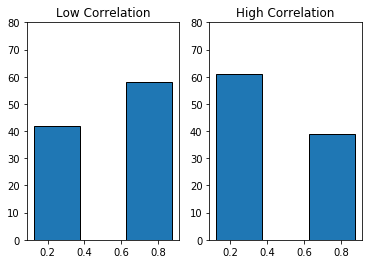

In [98]:
import matplotlib.pyplot as plt

# Assign 1 if LASSO has smaller pmse than Ridge(LASSO is better)
is_lasso_better = np.zeros((2,nsim))
for i in range(nsim):
    if (result[0,2,i] - result[0,1,i]) <= 0:
        is_lasso_better[0,i] = 1
    if (result[1,2,i] - result[1,1,i]) <= 0:
        is_lasso_better[1,i] = 1
    i = i+1
    
# Visualizing through histograms
plt.subplot(1,2,1)
hist_low = plt.hist(is_lasso_better[0,:], bins=2, rwidth=0.5, edgecolor='black')
plt.title('Low Correlation')
plt.ylim((0,80))

plt.subplot(1,2,2)
hist_high = plt.hist(is_lasso_better[1,:], bins=2, rwidth=0.5, edgecolor='black')
plt.title('High Correlation')
plt.ylim((0,80))

<p> As a result of 100 simulations in this setting, we can produce pmse for Ridge and LASSO in each setting of correlation. Bins on left indicates Ridge regression has better prediction performance. We can interpret the results as follows;  
    
+ Low Correlation  
Length of the bin on the left is shorter than one on the right. Which means, LASSO tends to have better performance than Ridge when the data has low correaltion. 

+ High Correlation
Opposite result produced in high correlation case. Ridge showed better performance than LASSO.
    
<p> Just in case if anyone is interested to check performance of Linear regression, I will plot similar histograms. 

(0, 110)

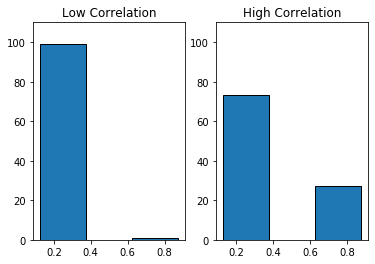

In [96]:
# Same as above, assign 1 if linear regression is better
is_lin_better = np.zeros((2,nsim))
for i in range(nsim):
    if (result[0,0,i] - result[0,1,i]) <= 0:
        is_lin_better[0,i] = 1
    if (result[1,0,i] - result[1,2,i]) <= 0:
        is_lin_better[1,i] = 1
    i = i+1

# Histograms
plt.subplot(1,2,1)
hist_low = plt.hist(is_lin_better[0,:], bins=2, rwidth=0.5, edgecolor='black')
plt.title('Low Correlation')
plt.ylim((0,110))

plt.subplot(1,2,2)
hist_high = plt.hist(is_lin_better[1,:], bins=2, rwidth=0.5, edgecolor='black')
plt.title('High Correlation')
plt.ylim((0,110))

<p> Right bins from the histograms represent number of simulated case which showed $\textbf{better}$ performance than other methods. For the comparing methods, I chose method that showed worse performance in each settings(Ridge for low correltion and LASSO for high correlation). It can be interpreted that linear regression generally has the worst performance over Ridge and LASSO. 

## 4. Conclusion

<p> As described in the chapter 2, motivation to start this project is to check if Ridge regression performs better than LASSO in highly correlated dataset. So I did 100 simulations and found out that Ridge tends to perform better than LASSO in high correlation. I just confirmed what my professor said about this relationship turned to be true. 

<p> I could see more clear results if the process of generating data is mathematically proven. So, if I get to study more deeply on this topic again in the future, I should have to take special care of this issue and find better way to do it. 